In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

def has_gaussian_noise(image, threshold=2):
    
    # Convert the image to grayscale if it's not already in grayscale
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Calculate the standard deviation of pixel values
    std_deviation = np.std(gray_image)

    # Check if the standard deviation is above the threshold
    if std_deviation > threshold:
        return True
    else:
        return False

def has_salt_and_pepper_noise(image, threshold=0.4):
    
    # Convert the image to grayscale if it's not already in grayscale
    if len(image.shape) == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image

    # Calculate the percentage of pixels with extreme values
    num_pixels = gray_image.size
    num_extreme_pixels = np.sum((gray_image == 0) | (gray_image == 255))
    percentage_extreme_pixels = num_extreme_pixels / num_pixels

    # Check if the percentage of extreme pixels is above the threshold
    if percentage_extreme_pixels > threshold:
        return True
    else:
        return False

def get_image_paths_and_labels(folder_path):
    image_paths = []
    labels = []

    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"The folder '{folder_path}' does not exist.")
        return image_paths, labels

    # Iterate through the files in the folder
    for filename in os.listdir(folder_path):
        file_path = os.path.join(folder_path, filename)

        # Check if the file is a valid image
        if os.path.isfile(file_path) and filename.lower().endswith(('.jpg', '.jpeg')):
            image_paths.append(file_path)
            labels.append(filename)  # Use the filename as the label
            
    return image_paths, labels

# Example functions for data preprocessing
def load_and_preprocess_data(image_paths, labels, target_size=(256, 256)):
    # Load and preprocess MRI images
    images = []
    for path in image_paths:
        try:
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale

            # Ensure the image has a valid size and aspect ratio
            if image is not None and image.shape[0] > 0 and image.shape[1] > 0:
                image = cv2.resize(image, target_size)  # Resize to a common size
                image = image / 255.0  # Normalize pixel values to [0, 1]
                images.append(image)
                
        except Exception as e:
            print(f"Error processing image at path {path}: {str(e)}")

    # Convert images and labels to NumPy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

def data_augmentation(images):
    # Example data augmentation (rotate, flip, and add noise)
    augmented_images = []
    for image in images:
        augmented_image = image.copy()  # Create a copy of the original image

        if has_gaussian_noise(augmented_image) == True:
            augmented_image = cv2.GaussianBlur(augmented_image, (5, 5), 0)

        if has_salt_and_pepper_noise(augmented_image) == True:
            augmented_image = cv2.medianBlur(np.float32(augmented_image), 5)

        augmented_images.append(augmented_image)

    return np.array(augmented_images)
           
def split_data(images, labels):
    try:
        # Split data into training, validation, and test sets
        X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

        return X_train, y_train, X_val, y_val, X_test, y_test
    except ValueError as e:
        print(f"ValueError occurred during data splitting: {str(e)}")
        return None, None, None, None, None, None

folder_path_tumor = "Brain Tumor Data Set\Brain Tumor Data Set\Brain Tumor"
image_paths_tumor, labels_tumor = get_image_paths_and_labels(folder_path_tumor)

folder_path_healthy = "Brain Tumor Data Set\Brain Tumor Data Set\Healthy"
image_paths_healthy, labels_healthy = get_image_paths_and_labels(folder_path_healthy)

image_paths = image_paths_healthy + image_paths_tumor
labels = labels_healthy + labels_tumor

for i in range(len(labels)) :
    if "Not Cancer  (" in labels[i] :
        labels[i] = 0
    elif "Cancer (" in labels[i]:
        labels[i] = 1

images, labels = load_and_preprocess_data(image_paths, labels)

# Data augmentation
augmented_images = data_augmentation(images)

# Split data (you had an issue here, so I fixed it)
X_train, y_train, X_val, y_val, X_test, y_test = split_data(augmented_images, labels)

# Check for errors and handle accordingly
if X_train is None:
    # Handle the error gracefully, e.g., print an error message or log it
    print("Error occurred during data splitting.")
else:
    # Continue with model training or further processing
    print("Data preprocessing completed successfully.")

Data preprocessing completed successfully.


In [9]:
from keras import Sequential
from keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, BatchNormalization, Dropout, PReLU, ELU
from keras.callbacks import EarlyStopping , ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

def custom_lr_schedule(epoch, current_lr):
    if epoch < 5:
        return 0.01  # Higher learning rate
    elif epoch < 12:
        return 0.001  # Medium learning rate
    else:
        return 0.0001  # Slower learning rate

lr_scheduler = LearningRateScheduler(custom_lr_schedule)
    
model = Sequential()
model.add(InputLayer(input_shape=(256,256,1)))
model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=128, kernel_size=3, activation=PReLU(), padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=256, kernel_size=3, activation=PReLU(), padding="same"))
model.add(MaxPool2D())
model.add(Flatten())
model.add(Dense(128, activation=ELU()))
model.add(BatchNormalization())
model.add(Dense(64, activation=ELU()))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5)
model_checkpoint = ModelCheckpoint('latest_check.h5', save_best_only=True)

model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 128)       598144    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 128)      

In [11]:
history = model.fit(X_train,y_train,batch_size=32,epochs=20,verbose=1,validation_data=(X_val,y_val),callbacks=[lr_scheduler,early_stopping, reduce_lr, model_checkpoint])

Epoch 1/20
99/99 [==============================] - ETA: 0s - loss: 0.6098 - accuracy: 0.6868

c:\Users\ariha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


99/99 [==============================] - 236s 2s/step - loss: 0.6098 - accuracy: 0.6868 - val_loss: 2.5013 - val_accuracy: 0.5968 - lr: 0.0100
Epoch 2/20
99/99 [==============================] - 236s 2s/step - loss: 0.4720 - accuracy: 0.7736 - val_loss: 0.6960 - val_accuracy: 0.6839 - lr: 0.0100
Epoch 3/20
99/99 [==============================] - 234s 2s/step - loss: 0.3592 - accuracy: 0.8486 - val_loss: 0.9593 - val_accuracy: 0.7016 - lr: 0.0100
Epoch 4/20
99/99 [==============================] - 231s 2s/step - loss: 0.2631 - accuracy: 0.8955 - val_loss: 1.9503 - val_accuracy: 0.5746 - lr: 0.0100
Epoch 5/20
99/99 [==============================] - 233s 2s/step - loss: 0.1863 - accuracy: 0.9351 - val_loss: 0.8173 - val_accuracy: 0.7976 - lr: 0.0100
Epoch 6/20
99/99 [==============================] - 226s 2s/step - loss: 0.1164 - accuracy: 0.9617 - val_loss: 0.3830 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 7/20
99/99 [==============================] - 234s 2s/step - loss: 0.0781 - accur

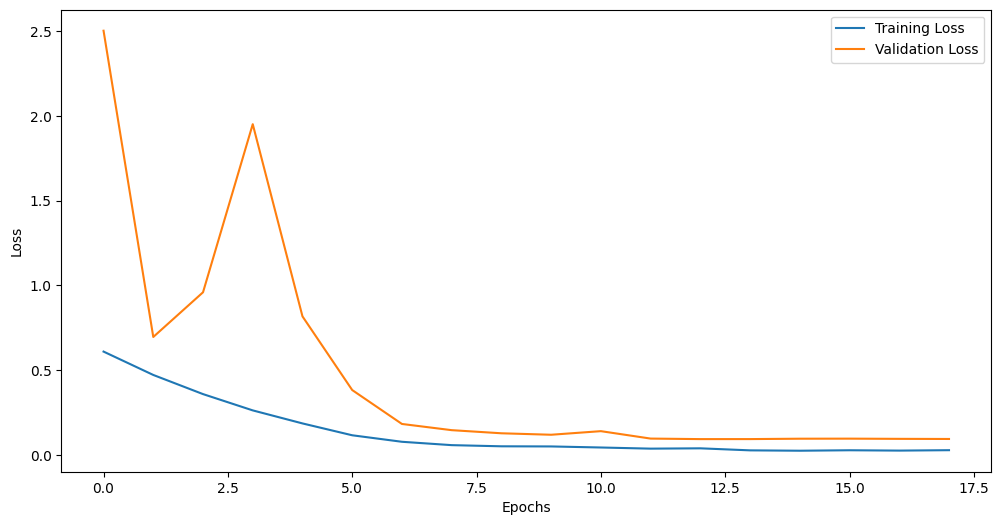

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

22/22 [==============================] - 11s 509ms/step


In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, mean_squared_error

# Accuracy
accuracy = accuracy_score(y_test,y_pred_binary)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test,y_pred_binary)
print("Precision:", precision)

# Recall
recall = recall_score(y_test,y_pred_binary)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test,y_pred_binary)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test,y_pred_binary)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(y_test,y_pred_binary)
auc = roc_auc_score(y_test,y_pred_binary)
print("AUC:", auc)

Accuracy: 0.9601181683899557
Precision: 0.9551451187335093
Recall: 0.9731182795698925
F1 Score: 0.9640479360852198
Confusion Matrix:
 [[288  17]
 [ 10 362]]
AUC: 0.9586902873259299


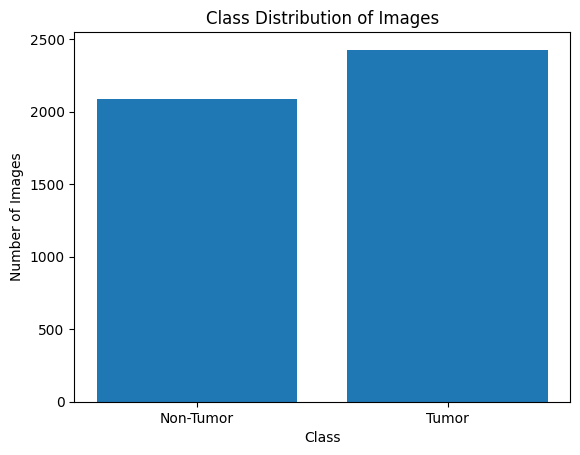

In [31]:
class_distribution = np.bincount(labels)

class_names = ["Non-Tumor", "Tumor"]

plt.bar(class_names, class_distribution)
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Class Distribution of Images")
plt.show()


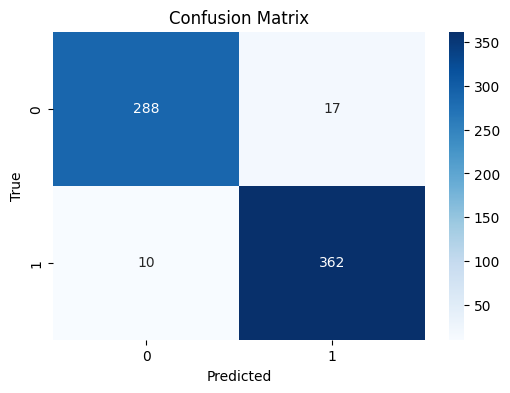

In [32]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

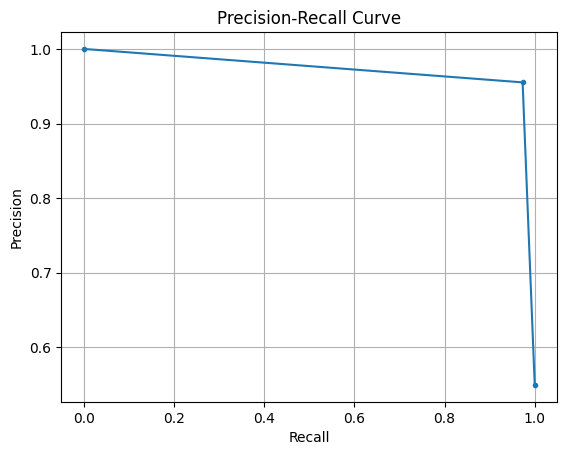

In [33]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_binary)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

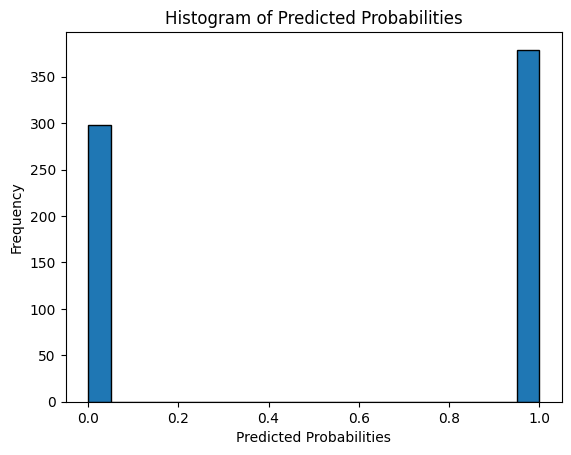

In [34]:
plt.hist(y_pred_binary, bins=20, edgecolor='k')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()

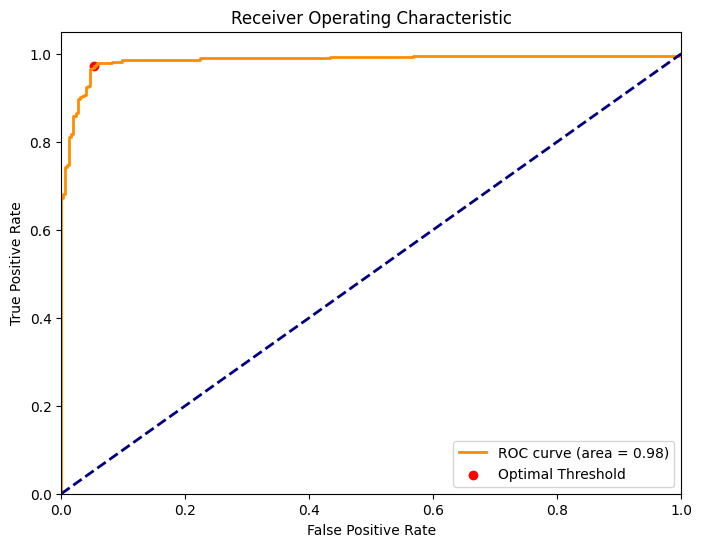

In [35]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

optimal_threshold_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_threshold_index]

plt.scatter(fpr[optimal_threshold_index], tpr[optimal_threshold_index], c='red', marker='o', label='Optimal Threshold')
plt.legend()

plt.show()

y_pred_binary = (y_pred >= optimal_threshold).astype(int)
